This is a classification problem. We'll try two methods to solve it: 
1. K-Means Clustering
2. Regression - likely with XGBoost decision trees
3. Machine Learning with PyTorch

In [108]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

In [109]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df = pd.concat([df_train, df_test], axis=0, sort=False).reset_index(drop=True)

n_train = df_train.shape[0]
n_test = df_test.shape[0]

In [110]:
excluded_columns = [
    'id'
]

target_column = 'Target'


onehotencode_columns = [
    "Marital status",
]

# Generally use for columns with large range, but still relatively small number of unique values
labelencode_columns = [
    "Application mode",
    "Course",
    "Previous qualification",
    "Nacionality",
]

standardscale_columns = [
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
    'Inflation rate', 'GDP'
]

encoders = {}


In [111]:
X = df.drop(columns=excluded_columns + [target_column])

for column in onehotencode_columns:
    encoders[column] = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoders[column].fit(df[column].values.reshape(-1, 1))

for column in labelencode_columns:
    encoders[column] = LabelEncoder()
    encoders[column].fit(df[column].values)

for column in standardscale_columns:
    encoders[column] = StandardScaler()
    encoders[column].fit(df[column].values.reshape(-1, 1))


for column in onehotencode_columns:
    encoded = encoders[column].transform(X[column].values.reshape(-1, 1))
    encoded = pd.DataFrame(encoded, columns=encoders[column].get_feature_names_out())
    X = pd.concat([X, encoded], axis=1)
    X.drop(columns=[column], inplace=True)

for column in labelencode_columns:
    X[column] = encoders[column].transform(X[column].values)

for column in standardscale_columns:
    X[column] = encoders[column].transform(X[column].values.reshape(-1, 1))


# Additionally, label encode the target column
encoders[target_column] = LabelEncoder()
encoders[target_column].fit(df[target_column].values)

y = encoders[target_column].transform(df[target_column].values)

X_train = X.values[:n_train]
X_test = X.values[n_train:]

y_train = y[:n_train]

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [113]:
model = XGBClassifier(eval_metric='merror')
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-merror:0.18688
[1]	validation_0-merror:0.18381
[2]	validation_0-merror:0.18146
[3]	validation_0-merror:0.18054
[4]	validation_0-merror:0.17956
[5]	validation_0-merror:0.17688
[6]	validation_0-merror:0.17629
[7]	validation_0-merror:0.17564
[8]	validation_0-merror:0.17518
[9]	validation_0-merror:0.17355
[10]	validation_0-merror:0.17309
[11]	validation_0-merror:0.17296
[12]	validation_0-merror:0.17283
[13]	validation_0-merror:0.17250
[14]	validation_0-merror:0.17250
[15]	validation_0-merror:0.17152
[16]	validation_0-merror:0.17074
[17]	validation_0-merror:0.17061
[18]	validation_0-merror:0.16969
[19]	validation_0-merror:0.16963
[20]	validation_0-merror:0.16963
[21]	validation_0-merror:0.16937
[22]	validation_0-merror:0.16937
[23]	validation_0-merror:0.16852
[24]	validation_0-merror:0.16832
[25]	validation_0-merror:0.16832
[26]	validation_0-merror:0.16780
[27]	validation_0-merror:0.16832
[28]	validation_0-merror:0.16786
[29]	validation_0-merror:0.16793
[30]	validation_0-me

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [114]:
y_pred = model.predict(X_test)

In [115]:
df_test[target_column] = encoders[target_column].inverse_transform(y_pred)

In [117]:
df_test[['id', target_column]].to_csv('submission.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

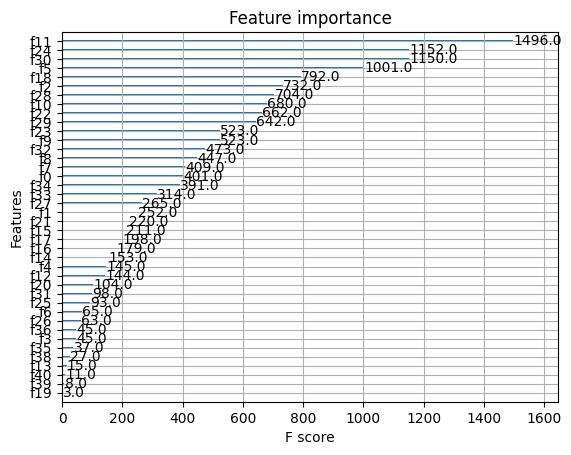

In [118]:
# Look at feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)

In [120]:
model.feature_importances_

array([0.00872187, 0.00657321, 0.01087373, 0.01077715, 0.00599538,
       0.00633269, 0.00479292, 0.00628613, 0.00616344, 0.0087348 ,
       0.00714817, 0.00698108, 0.0067194 , 0.00683568, 0.01502583,
       0.10393436, 0.01137413, 0.03825733, 0.00908164, 0.00445607,
       0.00781118, 0.01574156, 0.01644184, 0.03087194, 0.00852457,
       0.00581447, 0.01081761, 0.03810304, 0.03432838, 0.47637907,
       0.01499304, 0.00688586, 0.00733587, 0.00614311, 0.00921353,
       0.00600066, 0.00709926, 0.        , 0.00446882, 0.00454501,
       0.00341617], dtype=float32)

In [121]:
# Get feature importances as a dataframe
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

# Sort by importance and print
print(importance_df.sort_values('importance', ascending=False))

                                           feature  importance
29             Curricular units 2nd sem (approved)    0.476379
15                         Tuition fees up to date    0.103934
17                              Scholarship holder    0.038257
27             Curricular units 2nd sem (enrolled)    0.038103
28          Curricular units 2nd sem (evaluations)    0.034328
23             Curricular units 1st sem (approved)    0.030872
22          Curricular units 1st sem (evaluations)    0.016442
21             Curricular units 1st sem (enrolled)    0.015742
14                                          Debtor    0.015026
30                Curricular units 2nd sem (grade)    0.014993
16                                          Gender    0.011374
2                                           Course    0.010874
26             Curricular units 2nd sem (credited)    0.010818
3                       Daytime/evening attendance    0.010777
34                                             GDP    0